<a href="https://colab.research.google.com/github/primroseisaseal/Cryptocurrencies-forecast/blob/main/Code_2nd_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install xgboost==1.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# General
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import math
from sklearn.metrics import mean_squared_error

#LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#Technical analysis
import ta
from ta.trend import macd
from ta import momentum
from ta import trend
from ta import volatility
from ta import volume

#Feature delection
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


# xgboost
import xgboost
from xgboost import XGBRegressor
print("xgboost", xgboost.__version__)

xgboost 1.6.1


# Get features
-Dolatsara, H., Kibis, E., Caglar, M., Simsek, S., Dag, A., Dolatsara, G. and Delen, D., 2022. An interpretable decision-support systems for daily cryptocurrency trading. Expert Systems with Applications, 203, p.117409.
https://doi.org/10.1016/j.eswa.2022.117409

-Toledo, J. and Souza, D., 2022. Signal Prediction in Cryptocurrency Tradeoperations: A Machine Learning-Based Approach. SSRN Electronic Journal,.
https://dx.doi.org/10.2139/ssrn.4062476


In [ ]:
def get_features_14(data):
  data['MACD'] = macd(data['Close'], window_slow = 26, window_fast = 12)
  data['PPO'] = momentum.ppo(data['Close'], window_slow = 26, window_fast = 12)
  data['CCI'] = trend.cci(data['High'], data['Low'], data['Close'] )
  data['ROC'] = momentum.roc(data['Close'])
  data['Stochastic Oscillator'] = momentum.stoch(data['High'], data['Low'], data['Close'] )
  data['Williams_r'] = momentum.williams_r(data['High'], data['Low'], data['Close'])
  data['SMA_20'] = trend.sma_indicator(data['Close'], window =20)
  data['Open_SMA_3'] = trend.ema_indicator(data['Open'], window =3)
  data['Diff_OpenSMA3'] = data['Open_SMA_3'].diff(periods=1)
  data['EMA_20'] =trend.ema_indicator(data['Close'], window =20)
  data['Open_EMA_5'] = trend.ema_indicator(data['Open'], window =20)
  data['Diff_OpenEMA5'] = data['Open_EMA_5'].diff(periods=1)
  data.loc[data['Diff_OpenEMA5'] < 0, 'Movement_OpenEMA5'] = -1 
  data.loc[data['Diff_OpenEMA5'] > 0, 'Movement_OpenEMA5'] = 1 
  data['Diff_Close'] = data['Close'].diff(periods=1)
  data.loc[data['Diff_Close'] < 0, 'Movement_Close'] = -1 
  data.loc[data['Diff_Close'] > 0, 'Movement_Close'] = 1 
  data['Bollinger_Bands_L'] = volatility.bollinger_lband(data['Close'])
  data['Bollinger_Bands_M'] = volatility.bollinger_mavg(data['Close']) 
  data['Bollinger_Bands_H'] = volatility.bollinger_hband(data['Close'])
  data['OBV'] = volume.on_balance_volume(data['Close'], data['Volume'])
  data['Chaikin'] = volume.chaikin_money_flow(data['High'], data['Low'], data['Close'], data['Volume'])
  data['MFI'] = volume.money_flow_index(data['High'], data['Low'], data['Close'], data['Volume'])
  data['ATR'] = volatility.average_true_range(data['High'], data['Low'], data['Close'])
  data['Open_RSI'] = momentum.rsi(data['Open'])
  data['Close_RSI'] = momentum.rsi(data['Close'])
  data['Diff_CloseRSI'] = data['Close_RSI'].diff(periods=1)
  data.loc[data['Diff_CloseRSI'] < 0, 'Movement_closeRSI'] = -1 
  data.loc[data['Diff_CloseRSI'] > 0, 'Movement_closeRSI'] = 1 
  
  data['CloseEMA5'] = trend.ema_indicator(data['Close'], window =5)
  data['Diff_CloseEMA5'] = data['CloseEMA5'].diff(periods=1)
  data.loc[data['Diff_CloseEMA5'] < 0, 'Movement_Diff_CloseEMA5'] = -1 
  data.loc[data['Diff_CloseEMA5'] > 0, 'Movement_Diff_CloseEMA5'] = 1 
  data['CloseSMA3'] = trend.ema_indicator(data['Close'], window =3)
  data['Diff_CloseSMA3'] = data['CloseSMA3'].diff(periods=1)
  data.loc[data['Diff_CloseSMA3'] < 0, 'Movement_closeSMA3'] = -1 
  data.loc[data['Diff_CloseSMA3'] > 0, 'Movement_closeSMA3'] = 1
  return data

def get_gold_data(gold):
  gold['Movement_gold_Open'] = gold['Open'].diff(periods=1)
  gold['Open_RSI'] = momentum.rsi(gold['Open'])
  gold['Close_RSI'] = momentum.rsi(gold['Close'])
  gold = gold.iloc[:,6:]
  prefix = 'gold_'
  gold = gold.add_prefix(prefix)
  return gold


def get_data_DJI(DJI):
  DJI['Open_SMA20'] = trend.sma_indicator(DJI['Open'], window =20)
  DJI = DJI[['Volume', 'Open_SMA20']]
  prefix = 'DJI_'
  DJI = DJI.add_prefix(prefix)
  return DJI

def get_data_oil(oil):
  oil['Diff_close'] = oil['Close'].diff(periods=1)
  oil = oil[['Volume', 'Diff_close']]
  prefix = 'oil_'
  oil = oil.add_prefix(prefix)
  return oil

def get_data_usdeur(usdeur):
  usdeur['Open_SMA20'] = trend.sma_indicator(usdeur['Open'], window =20)
  usdeur = usdeur[['Open', 'Adj Close', 'Open_SMA20']]
  prefix = 'usdeur_'
  usdeur = usdeur.add_prefix(prefix)
  return usdeur

def get_data_usdcny(usdcny):
  usdcny = usdcny[['Open', 'Close', 'High']]
  prefix = 'usdcny_'
  usdcny = usdcny.add_prefix(prefix)
  
  return usdcny

In [ ]:
def get_overall_data(data, gold, dji, oil, usdeur, usdcny):
  DATA = get_features_14(data)
  GOLD = get_gold_data(gold)
  DJI = get_data_DJI(dji)
  OIL = get_data_oil(oil)
  USDEUR = get_data_usdeur(usdeur)
  USDCNY = get_data_usdcny(usdcny)
  final_data = DATA.merge(DJI, on='Date')
  final_data = final_data.merge(GOLD, on ='Date')
  final_data = final_data.merge(USDEUR, on ='Date')
  final_data = final_data.merge(OIL, on ='Date')
  final_data = final_data.merge(USDCNY, on ='Date')
  return final_data

# Features Selection

2 Groups:

1. Use original data provided by the API: High Low Close Open

2. Use attributes from the 2 papers above then use feature selection technic to get only relevent features.

Ref: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

In [ ]:

yf.pdr_override() 


def get_feature_groups(coin_ticker):
  #download data
  df_coin = pdr.get_data_yahoo(coin_ticker, start="2019-01-01", end="2022-06-15")
  gold = pdr.get_data_yahoo("GC=F", start="2019-01-01", end="2022-06-15")
  dji = pdr.get_data_yahoo("^DJI", start="2019-01-01", end="2022-06-15")
  oil = pdr.get_data_yahoo("CL=F", start="2019-01-01", end="2022-06-15")
  usdeur = pdr.get_data_yahoo("EUR=X", start="2019-01-01", end="2022-06-15")
  usdcny = pdr.get_data_yahoo("CNY=X", start="2019-01-01", end="2022-06-15")
  
  #create full df
  df_all_features = get_overall_data(df_coin, gold, dji, oil, usdeur, usdcny)
  df_all_features = df_all_features.dropna()

  # get group 1
  df_group_1 = df_all_features[['Open', 'Close', 'High', 'Low']]

  # get group 2
  X = df_all_features.drop('Close', axis =1)
  y = df_all_features['Close']
  # define feature selection
  fs = SelectKBest(score_func=f_regression, k=10)
  # apply feature selection
  X_selected = fs.fit_transform(X, y)
  features_name = fs.get_feature_names_out()
  X_selected = pd.DataFrame(X_selected, columns = features_name.tolist())
  X_selected['Close'] = np.array(df_all_features['Close'].values.tolist())
  X_selected
  df_group_2 = X_selected.copy()
  return df_group_1, df_group_2



# Multivariate LSTM

In [ ]:

def get_LSTM(df, Title, hop = 2, train_percent = 0.65):
  train_size = int(len(df)*train_percent)
  df_train = df.iloc[:train_size,1:]

  df_test = df.iloc[train_size:,1:]
  df_test['Close']= df_test['Close'].astype('float64')

  # For Training Set, split into X (Open, High, low, CLose) and y (Close) then scale it
  sc = MinMaxScaler(feature_range=(0,1))
  data_train_scaled = sc.fit_transform(df_train)

  sc2 = MinMaxScaler(feature_range=(0,1))
  y_train_scaled = sc2.fit_transform(df_train[['Close']])

  # create 3D df for LSTM
  X_train = []
  y_train = []
  for i in range(hop, train_size):
    X_train.append(data_train_scaled[i-hop:i])
    y_train.append(y_train_scaled[i][0])
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],  X_train.shape[2]))

  #fit trian df into the model
  model = Sequential()
  model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 50))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  model.fit(X_train, y_train, epochs = 100, batch_size = 32)

    # Prepaering for test data set
  train_lasthopdays = df_train.iloc[-hop:]
  full_df = pd.concat((train_lasthopdays,df_test), axis =0)
  full_df_scaled = sc.fit_transform(full_df)

  X_test = []
  for i in range(hop, len(full_df_scaled)):
    X_test.append(full_df_scaled[i-hop:i])

  X_test = np.array(X_test)

  full_df_scaled = pd.DataFrame(full_df_scaled)
  full_df_scaled.iloc[hop:,0:full_df_scaled.shape[1]-1]

  y_pred = model.predict(X_test)
  y_pred = pd.DataFrame(y_pred)
  y_pred = y_pred.rename(columns = {0 :'Close_pred'})

  full_df_scaled = pd.DataFrame(full_df_scaled)
  toinv_full = full_df_scaled.iloc[hop:,0:full_df_scaled.shape[1]-1].reset_index()
  toinv_full = toinv_full.iloc[:,1:]
  to_inv = pd.concat((toinv_full,y_pred), axis = 1)

  y_final_pred = sc.inverse_transform(to_inv)
  y_final_pred = pd.DataFrame(y_final_pred)

  full_final_df = pd.concat((df_test.reset_index(), y_final_pred.iloc[:,-1:]), axis =1)
  full_final_df

  Close_pred = full_final_df.iloc[:,-1:].values
  Close_actual = full_final_df['Close'].values
  print(f'RSME: {math.sqrt(mean_squared_error(Close_actual,Close_pred))}')

  plt.plot(full_final_df['Close'], color = 'black', label = 'Actual Price')
  plt.plot(full_final_df.iloc[:,-1:], color = 'green', label = 'Predicted Price')
  plt.title(f'Price Prediction by LSTM of {Title} ')
  plt.xlabel('Time')
  plt.ylabel('Price')
  plt.legend()
  plt.show()



# SVR for time series forecasting
https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/3-SVR/README.md

In [ ]:

def get_svm(df, Title, hop = 2, train_percent = 0.65):
  #Create dataframe for SVR
  df_lagged = df.copy()
  trailing_window_size = hop

  for window in range(1, trailing_window_size + 1):
      shifted = df.shift(window)
      shifted.columns = [x + "_lag" + str(window) for x in df.columns]
      
      df_lagged = pd.concat((df_lagged, shifted), axis=1)
  df_lagged = df_lagged.dropna()

  #split training and testing 65% /35%
  train_size = int(len(df)*train_percent)
  training_svr = df_lagged.iloc[:train_size,:]
  X_train_svr = training_svr.drop('Close',axis =1)
  y_train_svr = training_svr['Close']

  testing_svr = df_lagged.iloc[train_size:,:]
  X_test_svr = testing_svr.drop('Close',axis =1)
  y_test_svr = testing_svr['Close']


  #Scale data
  sc_df = MinMaxScaler(feature_range=(0,1))
  training_svr_scaled = sc_df.fit_transform(training_svr)
  training_svr_scaled = pd.DataFrame(training_svr_scaled,columns=training_svr.columns.values.tolist())
  X_train_svr_scaled = training_svr_scaled.drop('Close',axis =1)


  testing_svr_scaled = sc_df.transform(testing_svr)
  testing_svr_scaled = pd.DataFrame(testing_svr_scaled,columns=testing_svr.columns.values.tolist())
  X_test_svr_scaled = testing_svr_scaled.drop('Close',axis =1)

  #scaled y
  sc_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(df_lagged['Close']).reshape(-1,1))
  y_train_svr_scaled = sc_y.transform(np.array(y_train_svr).reshape(-1,1))


  #fit svr model into traning set
  svr = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
  svr.fit(X_train_svr_scaled,y_train_svr_scaled)
  y_train_svr_pred = svr.predict(X_train_svr_scaled)
  y_train_svr_pred

  # predict testing set
  y_test_svr_pred = svr.predict(X_test_svr_scaled)
  y_test_svr_pred = y_test_svr_pred.reshape(-1,1)


  y_test_vr_pred_inv = sc_y.inverse_transform(y_test_svr_pred)

  print(f'RSME: {math.sqrt(mean_squared_error(y_test_svr,y_test_vr_pred_inv))}')

  plt.plot(y_test_svr.values, color = 'black', label = 'Actual Price')
  plt.plot(y_test_vr_pred_inv, color = 'green', label = 'Predicted Price')
  plt.title(f'Price Prediction by SVR of {Title} ')
  plt.xlabel('Time')
  plt.ylabel('Price')
  plt.legend()
  plt.show()



#XG boost

In [ ]:

def get_XGB(df, Title, hop = 2, train_percent = 0.65):

  df_lagged = df.copy()
  trailing_window_size = hop

  for window in range(1, trailing_window_size + 1):
      shifted = df.shift(window)
      shifted.columns = [x + "_lag" + str(window) for x in df.columns]
      
      df_lagged = pd.concat((df_lagged, shifted), axis=1)
  df_lagged = df_lagged.dropna()

  #split training and testing 65% /35%
  train_size = int(len(df)*train_percent)
  training_xgb = df_lagged.iloc[:train_size,:]
  X_train_xgb = training_xgb.drop('Close',axis =1)
  y_train_xgb = training_xgb['Close']

  testing_xgb = df_lagged.iloc[train_size:,:]
  X_test_xgb = testing_xgb.drop('Close',axis =1)
  y_test_xgb = testing_xgb['Close']


  #Scale data
  sc_df = MinMaxScaler(feature_range=(0,1)).fit(df_lagged)
  training_xgb_scaled = sc_df.transform(training_xgb)
  training_xgb_scaled = pd.DataFrame(training_xgb_scaled,columns=training_xgb.columns.values.tolist())
  X_train_xgb_scaled = training_xgb_scaled.drop('Close',axis =1)


  testing_xgb_scaled = sc_df.transform(testing_xgb)
  testing_xgb_scaled = pd.DataFrame(testing_xgb_scaled,columns=testing_xgb.columns.values.tolist())
  X_test_xgb_scaled = testing_xgb_scaled.drop('Close',axis =1)

  #scaled y

  sc_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(df_lagged['Close']).reshape(-1,1))
  y_train_xgb_scaled = sc_y.transform(np.array(y_train_xgb).reshape(-1,1))

  #fit xgb model into traning set
  xgb = XGBRegressor()
  xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
  xgb.fit(X_train_xgb_scaled,y_train_xgb_scaled)
  y_train_xgb_pred = xgb.predict(X_train_xgb_scaled)

  # predict testing set
  y_test_xgb_pred = xgb.predict(X_test_xgb_scaled)
  y_test_xgb_pred = y_test_xgb_pred.reshape(-1,1)

  y_test_xgb_pred_inv = sc_y.inverse_transform(y_test_xgb_pred)
  print(f'RSME: {math.sqrt(mean_squared_error(y_test_xgb,y_test_xgb_pred_inv))}')


  plt.plot(y_test_xgb.values, color = 'black', label = 'Actual Price')
  plt.plot(y_test_xgb_pred_inv, color = 'green', label = 'Predicted Price')
  plt.title(f'Price Prediction by LSTM of {Title} ')
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()
  plt.show()

# Get 14 largest market cap crypto coins

In [ ]:
list_crypto = ['BTC', 'ETH-USD', 'USDT-USD', 'USDC-USD', 'BNB-USD', 'BUSD-USD', 
               'XRP-USD', 'ADA-USD', 'SOL-USD', 'DOGE-USD', 'DOT-USD','MATIC-USD', 
               'DAI-USD', 'AVAX-USD']


In [ ]:
d = {}
for crypto in list_crypto:
  d["df_" + str(crypto) + '_1'], d["df_" + str(crypto) + '_2'] = get_feature_groups(crypto)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# 1. BTC

Epoch 1/100
8/8 [==============================] - 9s 10ms/step - loss: 0.3597
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.2924
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1906
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0578
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0541
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0340
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0323
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0263
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0212
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0206
Epoch 11/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0155
Epoch 12/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0151
Epoch 13/100
8/8 [==============================]

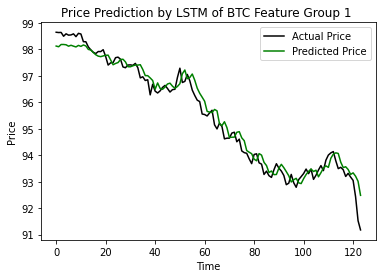

Epoch 1/100
8/8 [==============================] - 10s 11ms/step - loss: 0.3580
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.2764
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1398
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0420
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0341
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0273
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0215
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0216
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0190
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0163
Epoch 11/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0141
Epoch 12/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0162
Epoch 13/100
8/8 [==============================

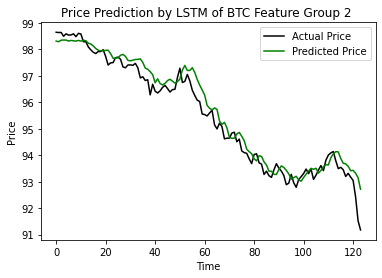

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 4.169512989260676


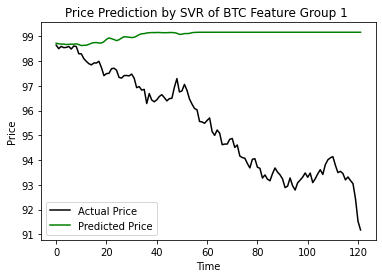

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 4.199117443805457


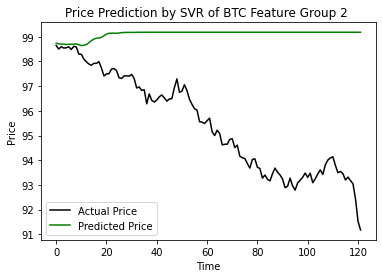

RSME: 3.364867250300359


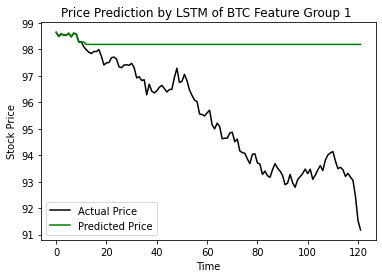

RSME: 3.3565456612824347


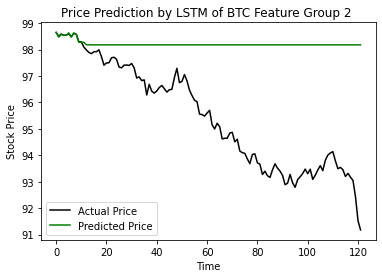

In [ ]:
get_LSTM(d['df_BTC_1'], 'BTC Feature Group 1')
get_LSTM(d['df_BTC_2'], 'BTC Feature Group 2')
get_svm(d['df_BTC_1'], 'BTC Feature Group 1')
get_svm(d['df_BTC_2'], 'BTC Feature Group 2')
get_XGB(d['df_BTC_1'], 'BTC Feature Group 1')
get_XGB(d['df_BTC_2'], 'BTC Feature Group 2')

# 2. ETH

Epoch 1/100
18/18 [==============================] - 11s 12ms/step - loss: 0.0650
Epoch 2/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0440
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0137
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0047
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0026
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0034
Epoch 7/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0031
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0031
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0028
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 11/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 12/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0016
Epoch 13/100
18/18 [====

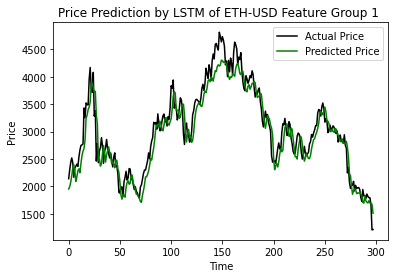

Epoch 1/100
18/18 [==============================] - 10s 14ms/step - loss: 0.0620
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0237
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0038
Epoch 4/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0033
Epoch 5/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0029
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0024
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0022
Epoch 8/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0019
Epoch 9/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0022
Epoch 10/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0027
Epoch 11/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0019
Epoch 12/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0023
Epoch 13/100
18/18 [====

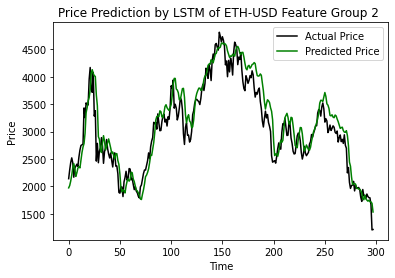

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 1788.9514392220494


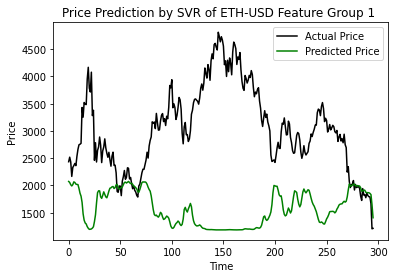

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 1910.2250889037687


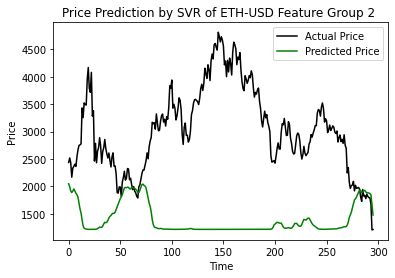

RSME: 1052.4124608260051


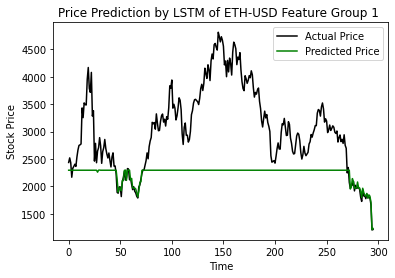

RSME: 1050.9629562393727


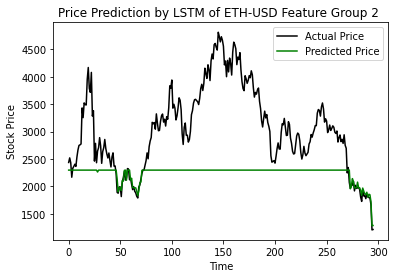

In [ ]:
get_LSTM(d['df_ETH-USD_1'], 'ETH-USD Feature Group 1')
get_LSTM(d['df_ETH-USD_2'], 'ETH-USD Feature Group 2')
get_svm(d['df_ETH-USD_1'], 'ETH-USD Feature Group 1')
get_svm(d['df_ETH-USD_2'], 'ETH-USD Feature Group 2')
get_XGB(d['df_ETH-USD_1'], 'ETH-USD Feature Group 1')
get_XGB(d['df_ETH-USD_2'], 'ETH-USD Feature Group 2')

# 3. USDT-USD


Epoch 1/100
18/18 [==============================] - 9s 14ms/step - loss: 0.0890
Epoch 2/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0122
Epoch 3/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0048
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0043
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0043
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0040
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0041
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0040
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0043
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0042
Epoch 11/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0038
Epoch 12/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0042
Epoch 13/100
18/18 [=====

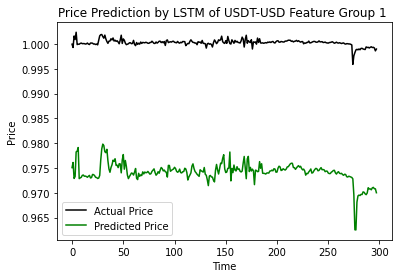

Epoch 1/100
18/18 [==============================] - 10s 12ms/step - loss: 0.0801
Epoch 2/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0069
Epoch 3/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0046
Epoch 4/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0038
Epoch 5/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0038
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0040
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0037
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0040
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0038
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0038
Epoch 11/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0038
Epoch 12/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0036
Epoch 13/100
18/18 [====

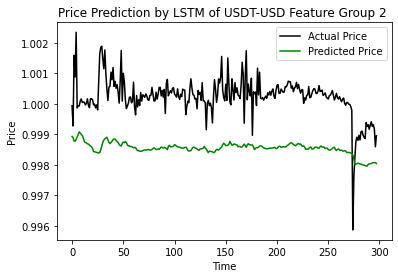

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 0.0009669921628364486


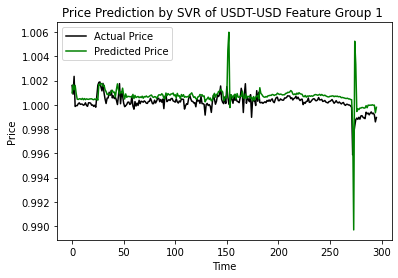

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 0.001126854379556578


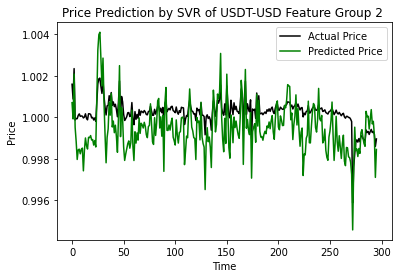

RSME: 0.0009382648472934359


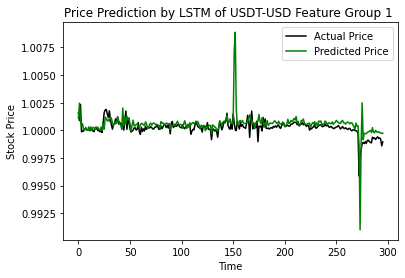

RSME: 0.00014904993819288742


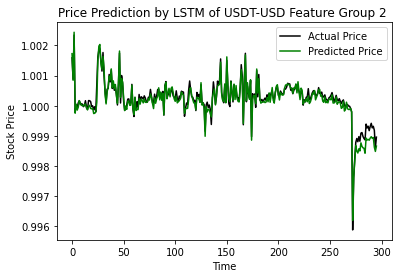

In [ ]:
get_LSTM(d['df_USDT-USD_1'], 'USDT-USD Feature Group 1')
get_LSTM(d['df_USDT-USD_2'], 'USDT-USD Feature Group 2')
get_svm(d['df_USDT-USD_1'], 'USDT-USD Feature Group 1')
get_svm(d['df_USDT-USD_2'], 'USDT-USD Feature Group 2')
get_XGB(d['df_USDT-USD_1'], 'USDT-USD Feature Group 1')
get_XGB(d['df_USDT-USD_2'], 'USDT-USD Feature Group 2')

# 4. USDC-USD

Epoch 1/100
18/18 [==============================] - 10s 12ms/step - loss: 0.1514
Epoch 2/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0250
Epoch 3/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0100
Epoch 4/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0083
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0073
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0065
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0066
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0070
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0062
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0070
Epoch 11/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 12/100
18/18 [==============================] - 0s 20ms/step - loss: 0.0070
Epoch 13/100
18/18 [====

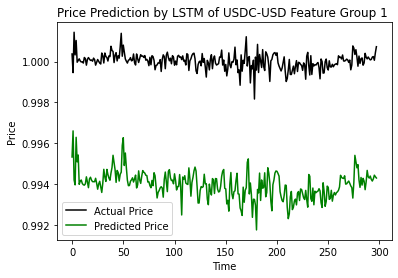

Epoch 1/100
18/18 [==============================] - 9s 10ms/step - loss: 0.1540
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0210
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0083
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0063
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0062
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0057
Epoch 8/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0058
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0060
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0055
Epoch 11/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0054
Epoch 12/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0058
Epoch 13/100
18/18 [=====

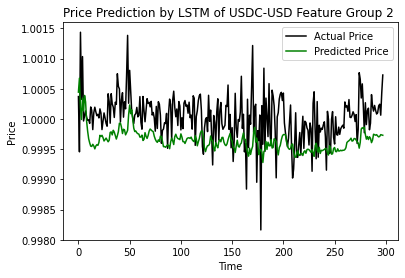

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 0.0028028009741293855


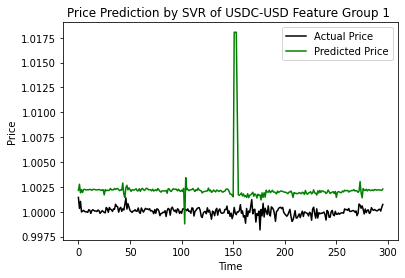

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 0.0021266238334313177


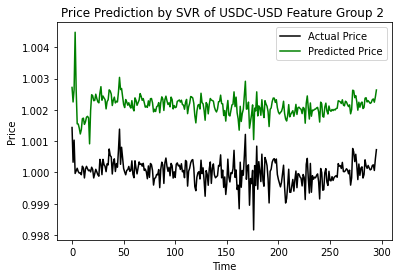

RSME: 0.0025834866802582584


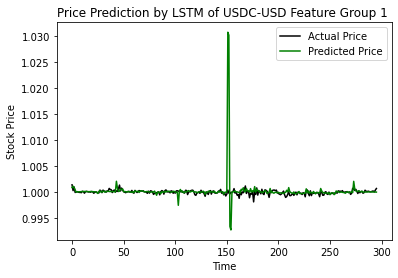

RSME: 0.00017285098301719775


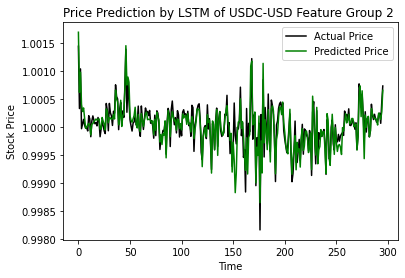

In [ ]:
get_LSTM(d['df_USDC-USD_1'], 'USDC-USD Feature Group 1')
get_LSTM(d['df_USDC-USD_2'], 'USDC-USD Feature Group 2')
get_svm(d['df_USDC-USD_1'], 'USDC-USD Feature Group 1')
get_svm(d['df_USDC-USD_2'], 'USDC-USD Feature Group 2')
get_XGB(d['df_USDC-USD_1'], 'USDC-USD Feature Group 1')
get_XGB(d['df_USDC-USD_2'], 'USDC-USD Feature Group 2')

# 5. 'BNB-USD'

Epoch 1/100
18/18 [==============================] - 9s 13ms/step - loss: 0.0245
Epoch 2/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0203
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0114
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0018
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 9.8663e-04
Epoch 7/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0012
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 11/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0015
Epoch 12/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 13/100
18/18 [=

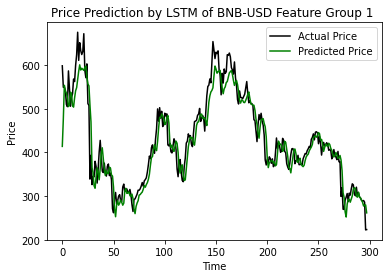

Epoch 1/100
18/18 [==============================] - 8s 10ms/step - loss: 0.0222
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0123
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0032
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0021
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0017
Epoch 7/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0016
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0016
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0012
Epoch 11/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 12/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0015
Epoch 13/100
18/18 [=====

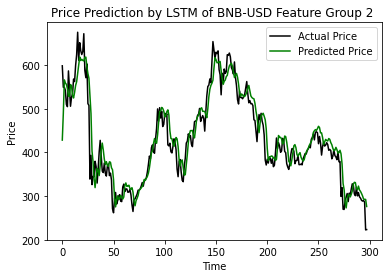

RSME: 55.91987081321034


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


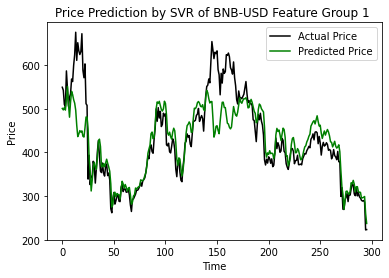

RSME: 138.03150313835175


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


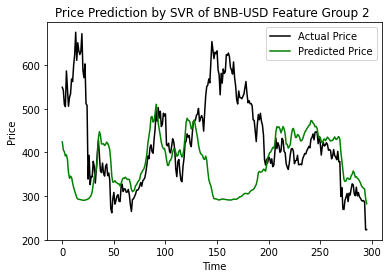

RSME: 34.83995514790563


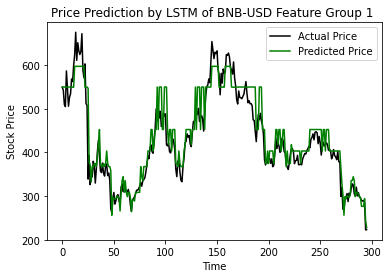

RSME: 34.91464761406379


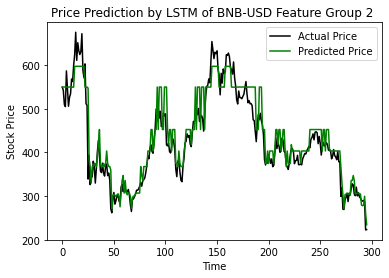

In [ ]:
get_LSTM(d['df_BNB-USD_1'], 'BNB-USD Feature Group 1')
get_LSTM(d['df_BNB-USD_2'], 'BNB-USD Feature Group 2')
get_svm(d['df_BNB-USD_1'], 'BNB-USD Feature Group 1')
get_svm(d['df_BNB-USD_2'], 'BNB-USD Feature Group 2')
get_XGB(d['df_BNB-USD_1'], 'BNB-USD Feature Group 1')
get_XGB(d['df_BNB-USD_2'], 'BNB-USD Feature Group 2')

# 6. 'BUSD-USD'

Epoch 1/100
13/13 [==============================] - 7s 9ms/step - loss: 0.1158
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0375
Epoch 3/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0075
Epoch 4/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0049
Epoch 5/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0041
Epoch 6/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 7/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 8/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 9/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 10/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0036
Epoch 11/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 12/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 13/100
13/13 [===============

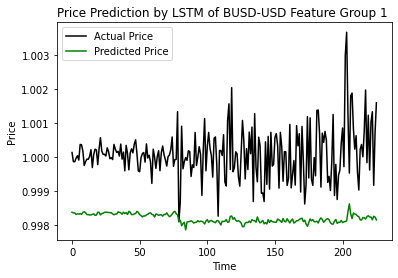

Epoch 1/100
13/13 [==============================] - 7s 8ms/step - loss: 0.1116
Epoch 2/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0269
Epoch 3/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0076
Epoch 4/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0050
Epoch 5/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0039
Epoch 6/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0036
Epoch 7/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 8/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0038
Epoch 9/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0040
Epoch 10/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0036
Epoch 11/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0038
Epoch 12/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 13/100
13/13 [==============

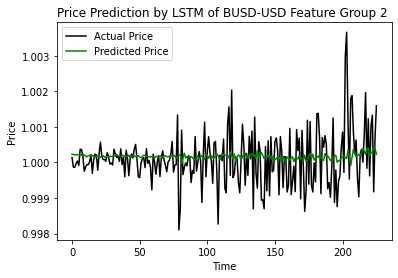

RSME: 0.0007509448632147784


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


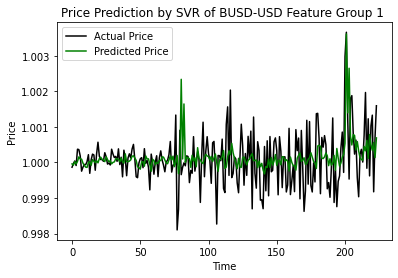

RSME: 0.0008244029675197589


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


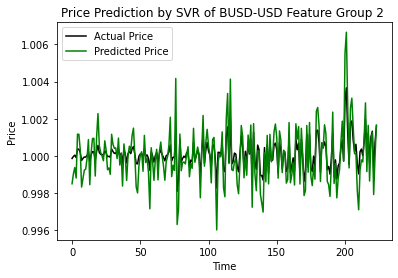

RSME: 0.0008675189359925862


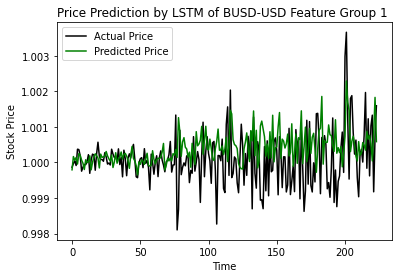

RSME: 0.0001858713838215988


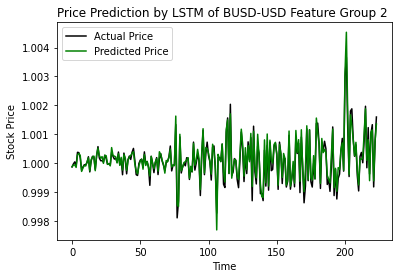

In [ ]:
get_LSTM(d['df_BUSD-USD_1'], 'BUSD-USD Feature Group 1')
get_LSTM(d['df_BUSD-USD_2'], 'BUSD-USD Feature Group 2')
get_svm(d['df_BUSD-USD_1'], 'BUSD-USD Feature Group 1')
get_svm(d['df_BUSD-USD_2'], 'BUSD-USD Feature Group 2')
get_XGB(d['df_BUSD-USD_1'], 'BUSD-USD Feature Group 1')
get_XGB(d['df_BUSD-USD_2'], 'BUSD-USD Feature Group 2')

# 7. 'XRP-USD'

Epoch 1/100
18/18 [==============================] - 8s 10ms/step - loss: 0.0313
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0160
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0122
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0058
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0024
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0030
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0028
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0027
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0029
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0025
Epoch 11/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0027
Epoch 12/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0024
Epoch 13/100
18/18 [=====

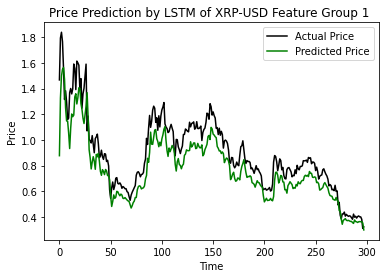

Epoch 1/100
18/18 [==============================] - 9s 12ms/step - loss: 0.0297
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0144
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0100
Epoch 4/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0049
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0037
Epoch 6/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0036
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0036
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0033
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0037
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0033
Epoch 11/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0035
Epoch 12/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0031
Epoch 13/100
18/18 [=====

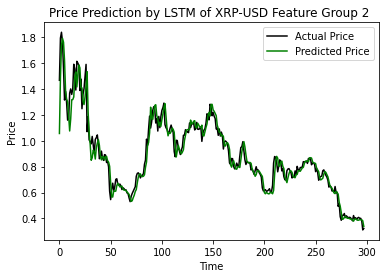

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 0.11053190995833342


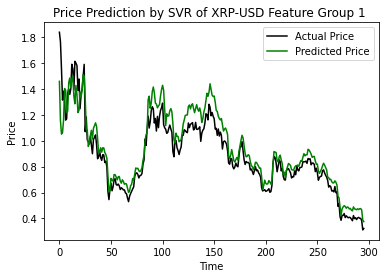

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 0.21452834279143543


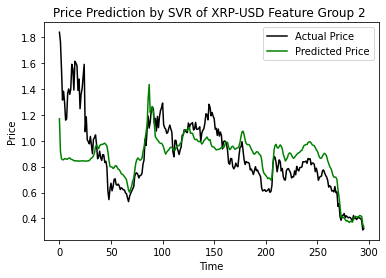

RSME: 0.10903524968459685


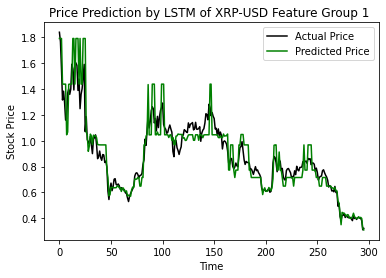

RSME: 0.10995765077935904


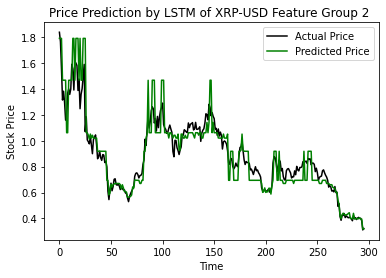

In [ ]:
get_LSTM(d['df_XRP-USD_1'], 'XRP-USD Feature Group 1')
get_LSTM(d['df_XRP-USD_2'], 'XRP-USD Feature Group 2')
get_svm(d['df_XRP-USD_1'], 'XRP-USD Feature Group 1')
get_svm(d['df_XRP-USD_2'], 'XRP-USD Feature Group 2')
get_XGB(d['df_XRP-USD_1'], 'XRP-USD Feature Group 1')
get_XGB(d['df_XRP-USD_2'], 'XRP-USD Feature Group 2')

# 8. 'ADA-USD'

Epoch 1/100
18/18 [==============================] - 9s 11ms/step - loss: 0.0475
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0372
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0149
Epoch 4/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0038
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0042
Epoch 6/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0019
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0016
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0021
Epoch 9/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0023
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0017
Epoch 11/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0016
Epoch 12/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 13/100
18/18 [=====

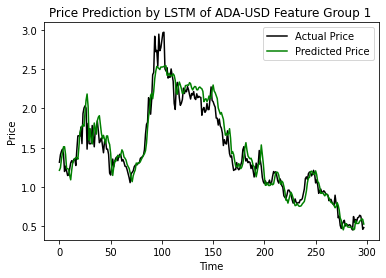

Epoch 1/100
18/18 [==============================] - 10s 13ms/step - loss: 0.0476
Epoch 2/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0288
Epoch 3/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0043
Epoch 4/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0030
Epoch 5/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0017
Epoch 6/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0019
Epoch 7/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0014
Epoch 8/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0021
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0012
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0015
Epoch 11/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0012
Epoch 12/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0016
Epoch 13/100
18/18 [====

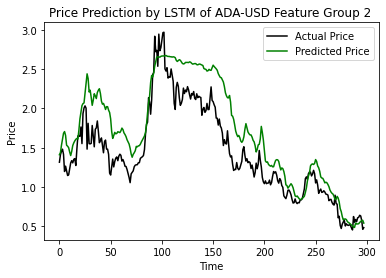

RSME: 0.7799880290883505


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


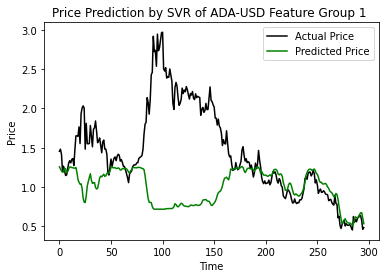

RSME: 0.8267016594794103


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


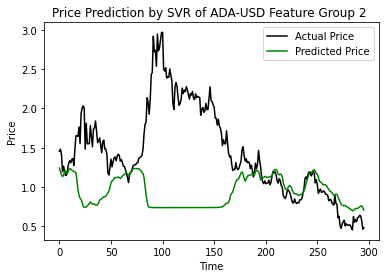

RSME: 0.4640229382786587


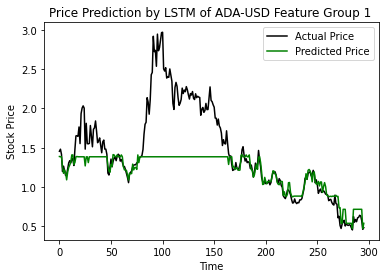

RSME: 0.476361630236607


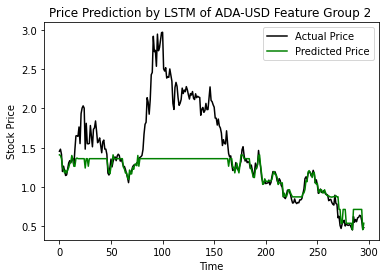

In [ ]:
get_LSTM(d['df_ADA-USD_1'], 'ADA-USD Feature Group 1')
get_LSTM(d['df_ADA-USD_2'], 'ADA-USD Feature Group 2')
get_svm(d['df_ADA-USD_1'], 'ADA-USD Feature Group 1')
get_svm(d['df_ADA-USD_2'], 'ADA-USD Feature Group 2')
get_XGB(d['df_ADA-USD_1'], 'ADA-USD Feature Group 1')
get_XGB(d['df_ADA-USD_2'], 'ADA-USD Feature Group 2')

# 9. 'SOL-USD'


Epoch 1/100
11/11 [==============================] - 9s 11ms/step - loss: 0.0348
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0276
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0259
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0214
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0095
Epoch 6/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0020
Epoch 7/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0064
Epoch 8/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0028
Epoch 9/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0022
Epoch 10/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0017
Epoch 11/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0016
Epoch 12/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0018
Epoch 13/100
11/11 [=====

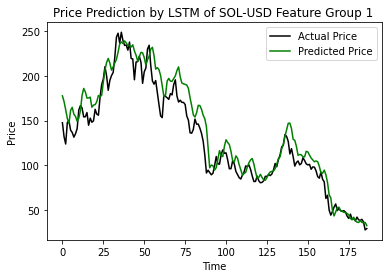

Epoch 1/100
11/11 [==============================] - 8s 10ms/step - loss: 0.0343
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0267
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0213
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0070
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0060
Epoch 6/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0028
Epoch 7/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0033
Epoch 8/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0022
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0022
Epoch 10/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0018
Epoch 11/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0017
Epoch 12/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 13/100
11/11 [=====

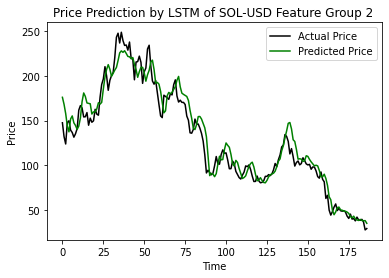

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 25.89399787956617


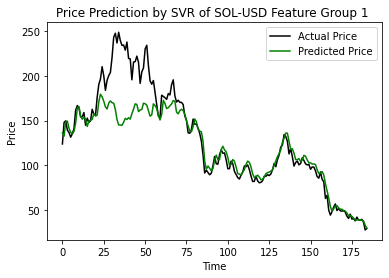

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 54.224719604397855


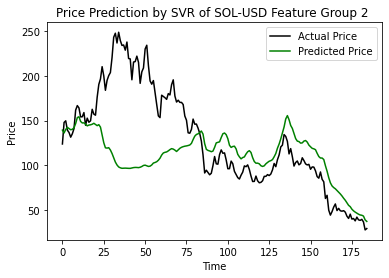

RSME: 17.59597628860752


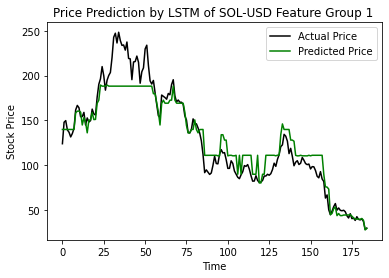

RSME: 17.972704711069394


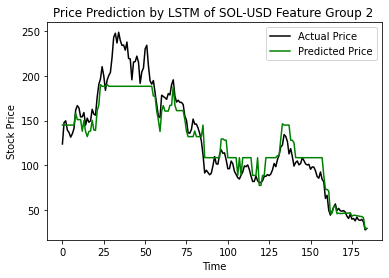

In [ ]:
get_LSTM(d['df_SOL-USD_1'], 'SOL-USD Feature Group 1')
get_LSTM(d['df_SOL-USD_2'], 'SOL-USD Feature Group 2')
get_svm(d['df_SOL-USD_1'], 'SOL-USD Feature Group 1')
get_svm(d['df_SOL-USD_2'], 'SOL-USD Feature Group 2')
get_XGB(d['df_SOL-USD_1'], 'SOL-USD Feature Group 1')
get_XGB(d['df_SOL-USD_2'], 'SOL-USD Feature Group 2')

# 10. 'DOGE-USD'

Epoch 1/100
18/18 [==============================] - 9s 10ms/step - loss: 0.0322
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0281
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0156
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0044
Epoch 5/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0030
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0026
Epoch 7/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0020
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 9/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0022
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 11/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0025
Epoch 12/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0022
Epoch 13/100
18/18 [=====

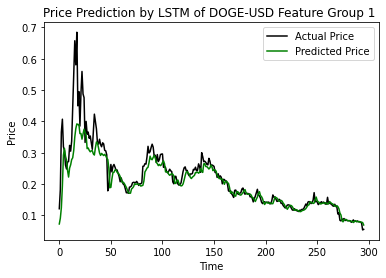

Epoch 1/100
18/18 [==============================] - 11s 13ms/step - loss: 0.0302
Epoch 2/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0153
Epoch 3/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0046
Epoch 4/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0030
Epoch 5/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0024
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0027
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0042
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0026
Epoch 9/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0020
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 11/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0021
Epoch 12/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0024
Epoch 13/100
18/18 [====

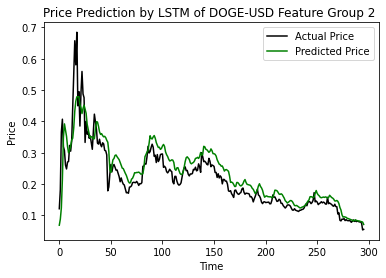

RSME: 0.16137947908137218


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


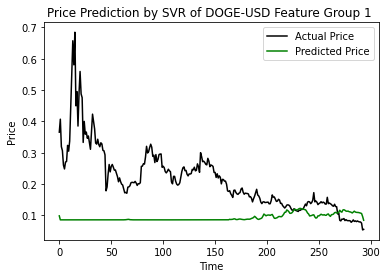

RSME: 0.16401797298686394


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


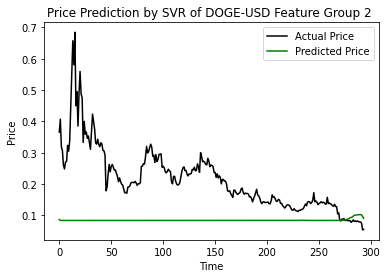

RSME: 0.1009885914156998


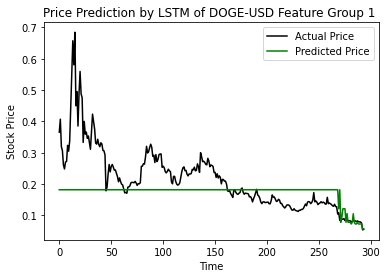

RSME: 0.10104022559946352


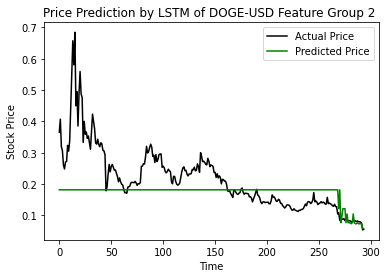

In [ ]:
get_LSTM(d['df_DOGE-USD_1'], 'DOGE-USD Feature Group 1')
get_LSTM(d['df_DOGE-USD_2'], 'DOGE-USD Feature Group 2')
get_svm(d['df_DOGE-USD_1'], 'DOGE-USD Feature Group 1')
get_svm(d['df_DOGE-USD_2'], 'DOGE-USD Feature Group 2')
get_XGB(d['df_DOGE-USD_1'], 'DOGE-USD Feature Group 1')
get_XGB(d['df_DOGE-USD_2'], 'DOGE-USD Feature Group 2')

# 11. 'DOT-USD'

Epoch 1/100
8/8 [==============================] - 10s 13ms/step - loss: 0.1923
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1498
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0984
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0563
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0447
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0309
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0191
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0129
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0115
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0092
Epoch 11/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0078
Epoch 12/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 13/100
8/8 [==============================

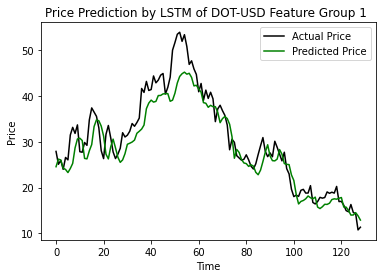

Epoch 1/100
8/8 [==============================] - 9s 10ms/step - loss: 0.1894
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1414
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0693
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0397
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0296
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0218
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0151
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0138
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0121
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0106
Epoch 11/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0093
Epoch 12/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0111
Epoch 13/100
8/8 [==============================]

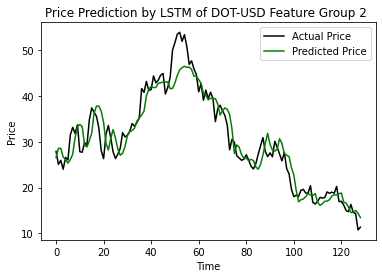

RSME: 3.411447797892005


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


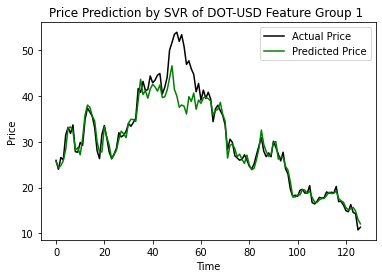

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 5.049373351454613


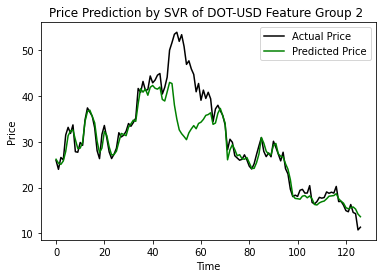

RSME: 2.1134568844775496


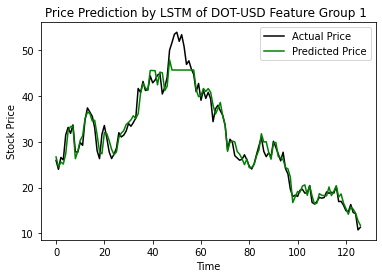

RSME: 2.2576000801071237


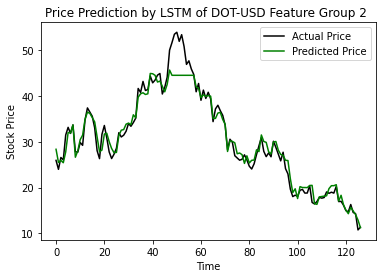

In [ ]:
get_LSTM(d['df_DOT-USD_1'], 'DOT-USD Feature Group 1')
get_LSTM(d['df_DOT-USD_2'], 'DOT-USD Feature Group 2')
get_svm(d['df_DOT-USD_1'], 'DOT-USD Feature Group 1')
get_svm(d['df_DOT-USD_2'], 'DOT-USD Feature Group 2')
get_XGB(d['df_DOT-USD_1'], 'DOT-USD Feature Group 1')
get_XGB(d['df_DOT-USD_2'], 'DOT-USD Feature Group 2')

# 12. 'MATIC-USD' 

Epoch 1/100
16/16 [==============================] - 9s 10ms/step - loss: 0.0087
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0083
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0075
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0030
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 8.9848e-04
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 9.8503e-04
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 9.6334e-04
Epoch 8/100
16/16 [==============================] - 0s 10ms/step - loss: 8.1276e-04
Epoch 9/100
16/16 [==============================] - 0s 11ms/step - loss: 8.1733e-04
Epoch 10/100
16/16 [==============================] - 0s 11ms/step - loss: 7.3076e-04
Epoch 11/100
16/16 [==============================] - 0s 11ms/step - loss: 9.8965e-04
Epoch 12/100
16/16 [==============================] - 0s 12ms/step - loss: 5.03

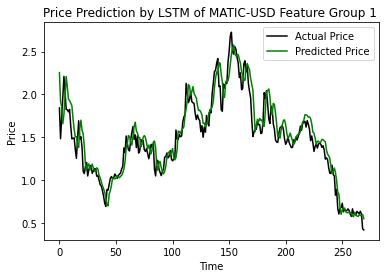

Epoch 1/100
16/16 [==============================] - 10s 13ms/step - loss: 0.0087
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0079
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0047
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0016
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0012
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 7/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0012
Epoch 8/100
16/16 [==============================] - 0s 11ms/step - loss: 7.0885e-04
Epoch 9/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0012
Epoch 10/100
16/16 [==============================] - 0s 11ms/step - loss: 5.8411e-04
Epoch 11/100
16/16 [==============================] - 0s 10ms/step - loss: 9.3991e-04
Epoch 12/100
16/16 [==============================] - 0s 12ms/step - loss: 7.1075e-04
Epoch 13

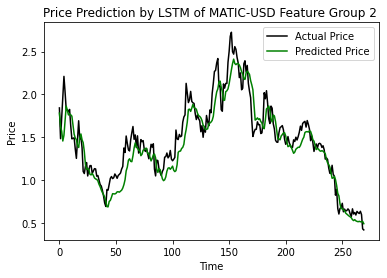

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 0.2846896731162998


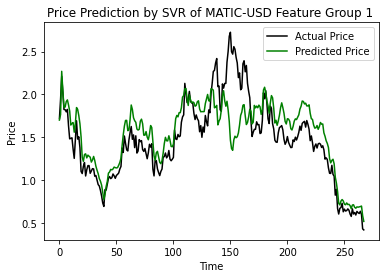

RSME: 0.5114687231878766


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


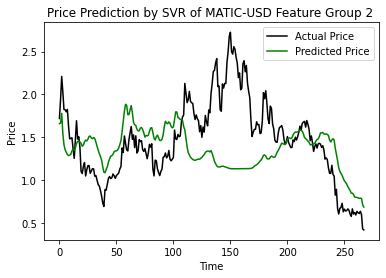

RSME: 0.2126474881666195


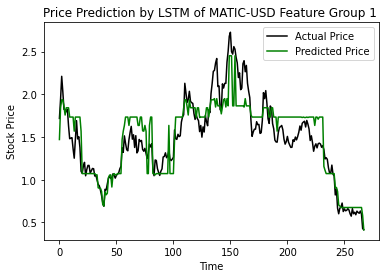

RSME: 0.2186391919147584


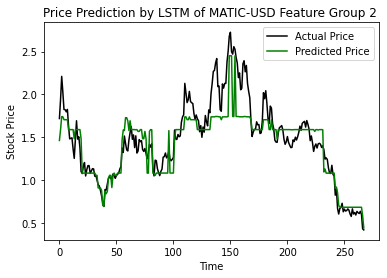

In [ ]:
get_LSTM(d['df_MATIC-USD_1'], 'MATIC-USD Feature Group 1')
get_LSTM(d['df_MATIC-USD_2'], 'MATIC-USD Feature Group 2')
get_svm(d['df_MATIC-USD_1'], 'MATIC-USD Feature Group 1')
get_svm(d['df_MATIC-USD_2'], 'MATIC-USD Feature Group 2')
get_XGB(d['df_MATIC-USD_1'], 'MATIC-USD Feature Group 1')
get_XGB(d['df_MATIC-USD_2'], 'MATIC-USD Feature Group 2')

# 13. 'DAI-USD'

Epoch 1/100
13/13 [==============================] - 11s 14ms/step - loss: 0.0855
Epoch 2/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0256
Epoch 3/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0104
Epoch 4/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0076
Epoch 5/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0068
Epoch 6/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0064
Epoch 7/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0067
Epoch 8/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0066
Epoch 9/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0063
Epoch 10/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0063
Epoch 11/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0063
Epoch 12/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0064
Epoch 13/100
13/13 [====

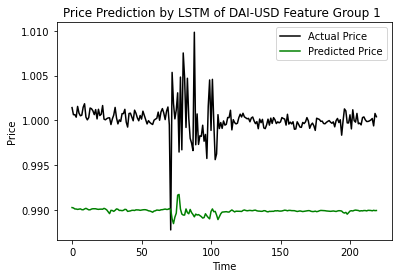

Epoch 1/100
13/13 [==============================] - 9s 11ms/step - loss: 0.0826
Epoch 2/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0203
Epoch 3/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0080
Epoch 4/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0062
Epoch 5/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 6/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0055
Epoch 7/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0056
Epoch 8/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0058
Epoch 9/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0055
Epoch 10/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0057
Epoch 11/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0060
Epoch 12/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0055
Epoch 13/100
13/13 [=====

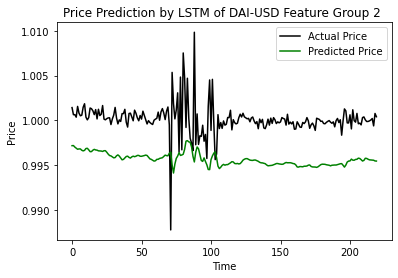

RSME: 0.003134834276456904


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


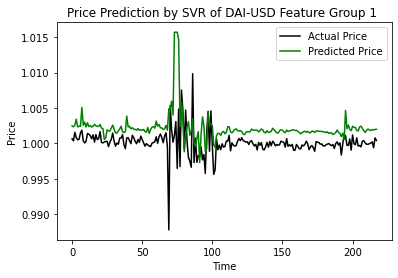

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 0.0029960667178271587


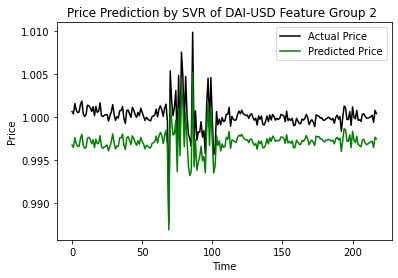

RSME: 0.0028974396451858773


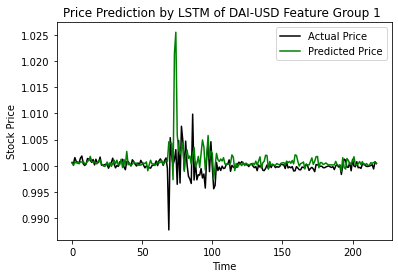

RSME: 0.0006080761077340798


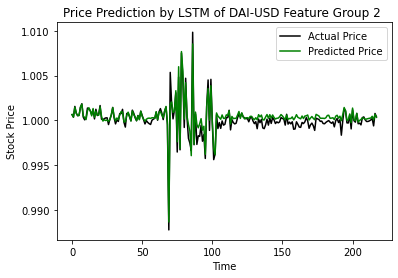

In [ ]:
get_LSTM(d['df_DAI-USD_1'], 'DAI-USD Feature Group 1')
get_LSTM(d['df_DAI-USD_2'], 'DAI-USD Feature Group 2')
get_svm(d['df_DAI-USD_1'], 'DAI-USD Feature Group 1')
get_svm(d['df_DAI-USD_2'], 'DAI-USD Feature Group 2')
get_XGB(d['df_DAI-USD_1'], 'DAI-USD Feature Group 1')
get_XGB(d['df_DAI-USD_2'], 'DAI-USD Feature Group 2')

# 14. 'AVAX-USD'

Epoch 1/100
9/9 [==============================] - 9s 10ms/step - loss: 0.1204
Epoch 2/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0856
Epoch 3/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0475
Epoch 4/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0392
Epoch 5/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0233
Epoch 6/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0126
Epoch 7/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0080
Epoch 8/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0072
Epoch 9/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0064
Epoch 10/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0074
Epoch 11/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0068
Epoch 12/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0067
Epoch 13/100
9/9 [==============================] 

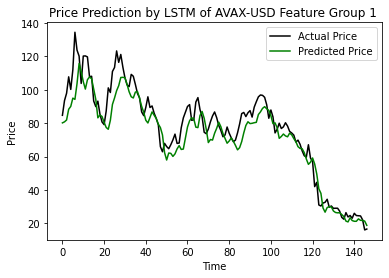

Epoch 1/100
9/9 [==============================] - 10s 13ms/step - loss: 0.1184
Epoch 2/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0780
Epoch 3/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0356
Epoch 4/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0296
Epoch 5/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0190
Epoch 6/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0094
Epoch 7/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0088
Epoch 8/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0089
Epoch 9/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0070
Epoch 10/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0067
Epoch 11/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0063
Epoch 12/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0077
Epoch 13/100
9/9 [==============================

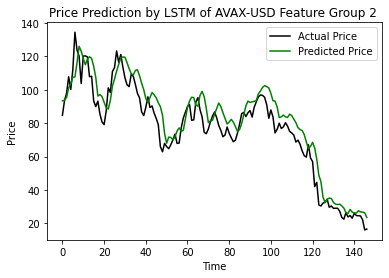

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 16.68469764121312


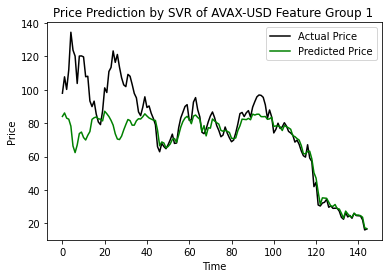

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RSME: 26.21875590842657


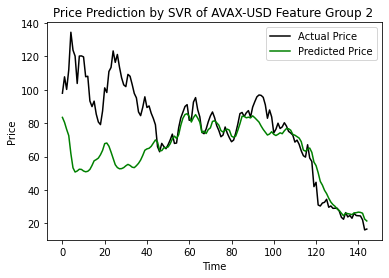

RSME: 9.294144740551829


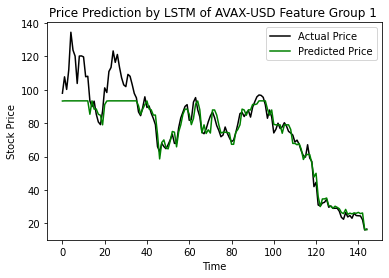

RSME: 9.330623396205683


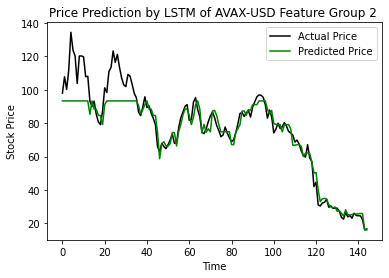

In [ ]:
get_LSTM(d['df_AVAX-USD_1'], 'AVAX-USD Feature Group 1')
get_LSTM(d['df_AVAX-USD_2'], 'AVAX-USD Feature Group 2')
get_svm(d['df_AVAX-USD_1'], 'AVAX-USD Feature Group 1')
get_svm(d['df_AVAX-USD_2'], 'AVAX-USD Feature Group 2')
get_XGB(d['df_AVAX-USD_1'], 'AVAX-USD Feature Group 1')
get_XGB(d['df_AVAX-USD_2'], 'AVAX-USD Feature Group 2')